<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Смотрю-возраст-с-малым-числом-людей" data-toc-modified-id="Смотрю-возраст-с-малым-числом-людей-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Смотрю возраст с малым числом людей</a></span></li><li><span><a href="#смотрю-на-корреляцию" data-toc-modified-id="смотрю-на-корреляцию-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>смотрю на корреляцию</a></span></li><li><span><a href="#Обработка-категориальных-признаков," data-toc-modified-id="Обработка-категориальных-признаков,-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обработка категориальных признаков,</a></span></li><li><span><a href="#Добавление-фич" data-toc-modified-id="Добавление-фич-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Добавление фич</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, make_scorer

import random
from imblearn.base import FunctionSampler

In [3]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.precision', 2)

In [4]:
random.seed(42)

## Подготовка данных

In [5]:
df = pd.read_csv('/datasets/Churn.csv')

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df_obj = df.loc[:, df.dtypes == object]

In [8]:
df[df.duplicated(subset=['CustomerId'])]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [9]:
df['Surname'].value_counts()

Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
            ..
Raff         1
O'Kane       1
Seccombe     1
Speight      1
Bancks       1
Name: Surname, Length: 2932, dtype: int64

In [10]:
def wrap_object(df): 
    for i in df:
        print('-----------------------------------')
        print(f'|---------   {i}   -----------|')
        print('-----------------------------------')
        df_unique_nums = df[i].nunique()
        print(f' кол-во уникальных значений - {df_unique_nums}')
        if df_unique_nums > 10:
            df_vc = df[i].value_counts()
            print(f' 5 наиболее частых: \n{df_vc[0:5]}')
            print(f' 5 наиболее редких: \n{df_vc.tail()}')
        else:
            print(f' уникальные значения: \n{df[i].unique()}')
            print(f'Частота уникальных значений: \n{df[i].value_counts()}')
        
        
    return 0

In [11]:
wrap_object(df_obj)

-----------------------------------
|---------   Surname   -----------|
-----------------------------------
 кол-во уникальных значений - 2932
 5 наиболее частых: 
Smith     32
Martin    29
Scott     29
Walker    28
Brown     26
Name: Surname, dtype: int64
 5 наиболее редких: 
Raff        1
O'Kane      1
Seccombe    1
Speight     1
Bancks      1
Name: Surname, dtype: int64
-----------------------------------
|---------   Geography   -----------|
-----------------------------------
 кол-во уникальных значений - 3
 уникальные значения: 
['France' 'Spain' 'Germany']
Частота уникальных значений: 
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
-----------------------------------
|---------   Gender   -----------|
-----------------------------------
 кол-во уникальных значений - 2
 уникальные значения: 
['Female' 'Male']
Частота уникальных значений: 
Male      5457
Female    4543
Name: Gender, dtype: int64


0

**Заметка**  
- France     5014  
- Germany    2509   
- Spain      2477  
Франция тут явно перевешивает  

есть редкие(1) и частые(~30) фамилии  
  
- Male      5457  
- Female    4543  
мужчин немного больше но не существенно  

In [12]:
df.rename({"RowNumber" : "row_number",
           "CustomerId" : "customer_id", 
           "CreditScore":"credit_score",
           "NumOfProducts" : "num_of_products", 
           "HasCrCard": "has_credit_card", 
           "IsActiveMember" : "is_active_member", 
           "EstimatedSalary" : "estimated_salary"}, inplace=True, axis=1)


In [13]:
df.rename(str.lower, axis=1, inplace=True)

**Заметка**  
Название колонок преведены к snake_case

In [14]:
df

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Сразу удалю row_number,surname , так как точно не поможет в обучении модели  
customer_id поставлю вместо индексов

In [15]:
df.drop(['row_number','surname'], inplace=True, axis=1)

In [16]:
df.set_index('customer_id', inplace=True)

In [17]:
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
15606229,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
15569892,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
15584532,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


In [18]:
df.sample(5)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15591344,715,Spain,Male,42,6.0,0.00,2,1,1,128745.69,0
15769955,683,France,Female,40,1.0,0.00,2,0,0,75762.00,0
15802585,634,France,Female,41,8.0,68213.99,1,1,1,6382.46,0
15726676,616,Spain,Male,30,5.0,0.00,2,0,1,196108.51,0
15778089,544,Spain,Male,37,NaN,0.00,2,0,0,135067.02,0


In [19]:
df.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15606229,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
15569892,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
15584532,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
15682355,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
15628319,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [20]:
df.describe()

,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
count,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.2
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.0
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_credit_card   10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 937.5+ KB


In [22]:
numerical_names = ['credit_score', 'age', 'tenure', 'num_of_products', 'estimated_salary', 'balance']

**Промежуточные выводы**  
Пропуски в Tenure 9091 - нон налов     
то что не дает инфы : 
- row_number    
- customer_id    
- surname    
  
категориальные признаки  :    
- geography  
----    
категориальные бинарные признаки  
- gender  
- has_credit_card  
- is_active_member  
----
количественные непрерывные  
- balance  
- estimated_salary  
----
количественные дискретные   
- credit_score      
- age  
- tenure  
- num_of_products  

In [23]:
duplicates = df.duplicated()
df[duplicates]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,


**Заметка**  
Явных дубликатов - нет

In [24]:
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [25]:
df[df['tenure'].isna()]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15589475,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
15766205,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
15768193,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
15702298,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
15651280,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
15703923,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
15707861,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
15642785,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0


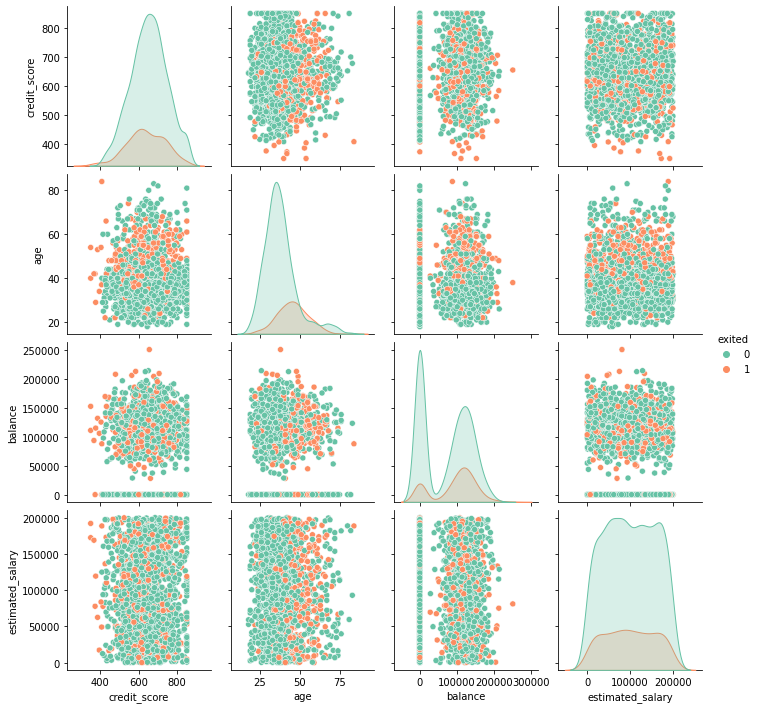

In [26]:
sns.pairplot(data=df.sample(2000).drop(['has_credit_card','is_active_member','num_of_products','tenure'],axis=1).select_dtypes(include=['number']),hue='exited',diag_kind='kde',palette="Set2")   
plt.show()

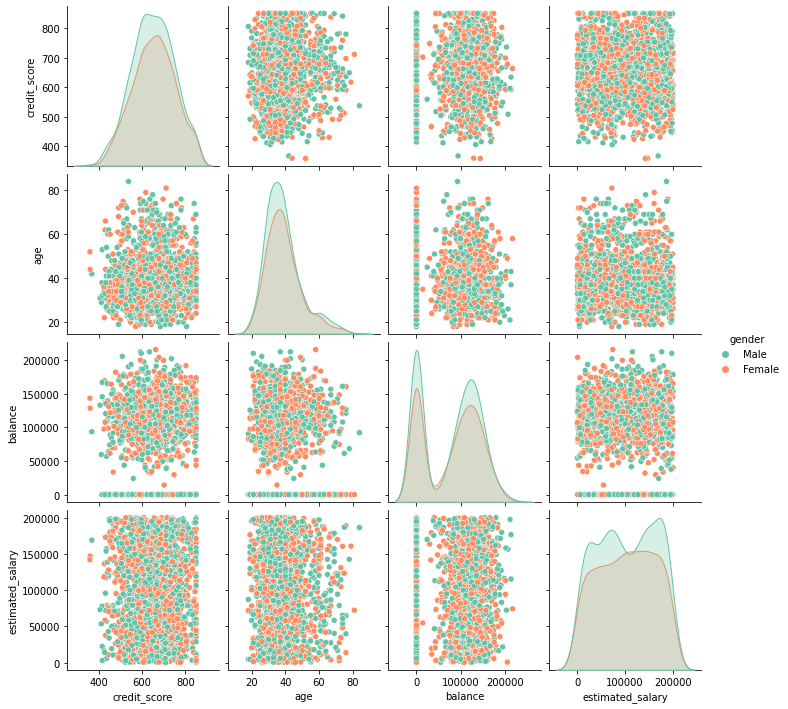

In [27]:
sns.pairplot(data=df.loc[:,['credit_score','age','balance','estimated_salary','gender']].sample(2000),hue='gender',diag_kind='kde',palette="Set2")   
plt.show()

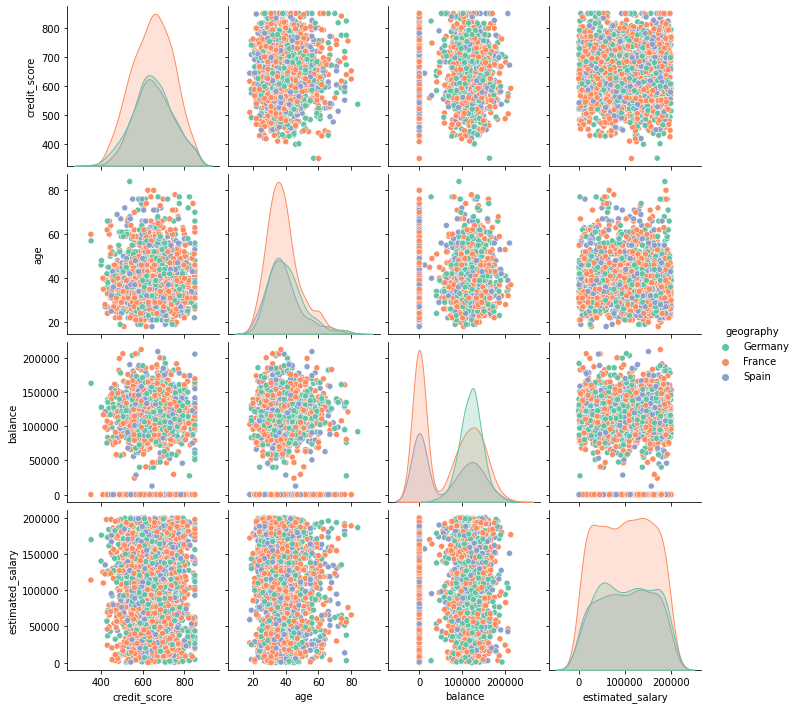

In [28]:
sns.pairplot(data=df[['credit_score', 'age','balance','estimated_salary','geography']].sample(2000),hue='geography',diag_kind='kde',palette="Set2")   
plt.show()

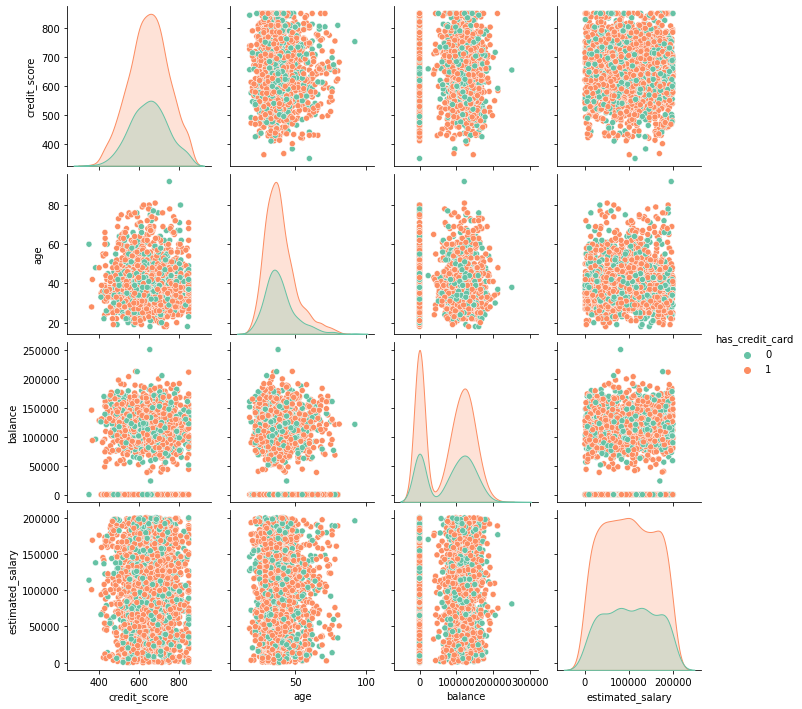

In [29]:

sns.pairplot(data=df[['credit_score', 'age','balance','estimated_salary','has_credit_card']].sample(2000),hue='has_credit_card',diag_kind='kde',palette="Set2")   
plt.show()


- Есть много клиентов с нулевым - около нулевым балансом  
-  Остальные данные по взгляду на данные графики хоть и имеют некоторые  'выбросы', но все эти выбросы похожи на реальность. 

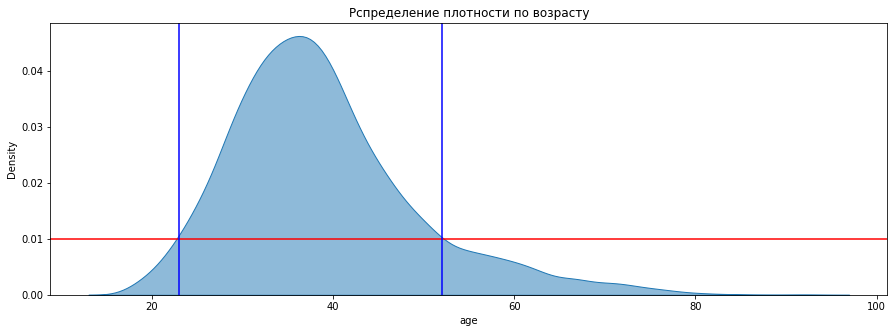

In [30]:

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(data=df, x="age", fill=True, alpha=.5)
# Построение прямой горизонтальной линии
ax.axhline(y=0.01, color='r', linestyle='-')
ax.axvline(x=23, color='b', linestyle='-')
ax.axvline(x=52, color='b', linestyle='-')
plt.title('Рспределение плотности по возрасту')
plt.show()


**Заметка**  
Надо посмотреть что у Nan-значений в местах с маленькой плотностью  -> то есть ~ от 18 до 23 и от 52 до 92

In [31]:
df[df['tenure'].isna() == False].groupby(['geography','gender'])['tenure'].agg(['mean','median','count'])

mean  median  count
geography gender                     
France    Female  4.94     5.0   2044
          Male    5.05     5.0   2506
Germany   Female  4.95     5.0   1085
          Male    5.01     5.0   1208
Spain     Female  4.99     5.0    988
          Male    5.01     5.0   1260

С первого взгляда пол не играет роли

In [32]:
z = df[df['tenure'].isna() == False].groupby(['geography','gender','age'])['tenure'].agg(['mean','median','count'])['mean'].reset_index()


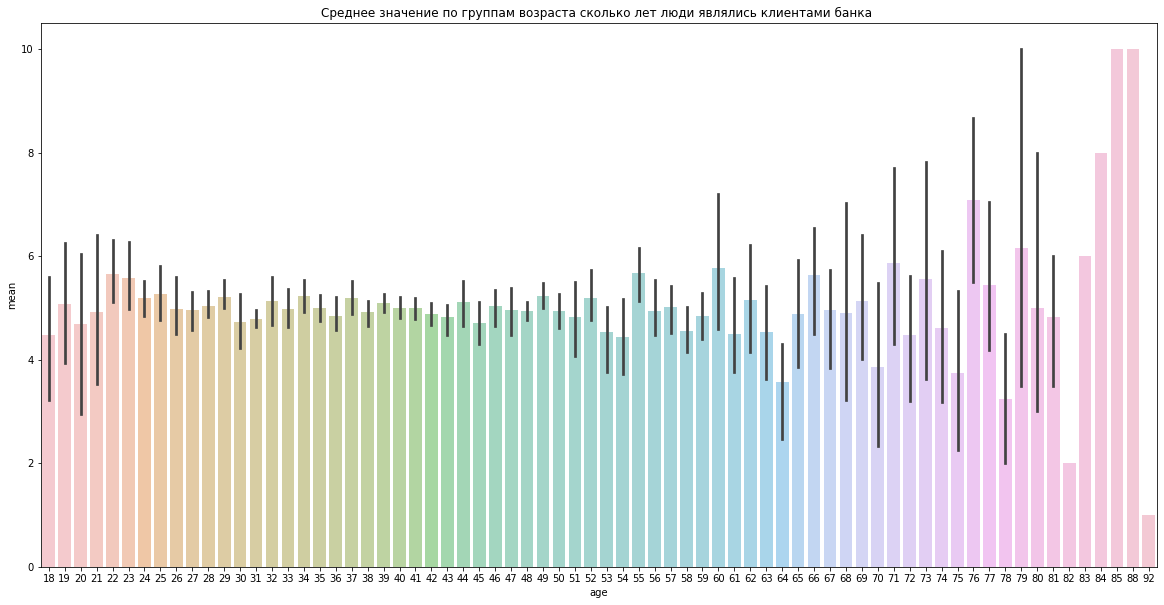

In [33]:
plt.figure(figsize=(20,10))
sns.barplot(data=z, x="age",y="mean", alpha=.5)
plt.title('Среднее значение по группам возраста сколько лет люди являлись клиентами банка ')
plt.show()

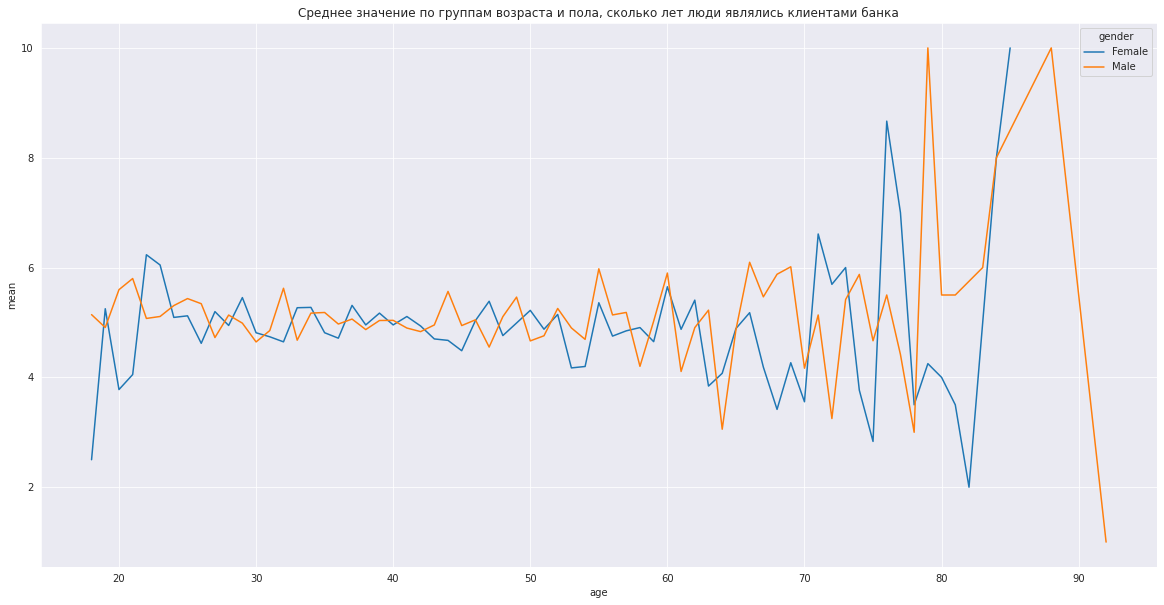

In [34]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.lineplot(data=z, x="age",y="mean",hue="gender",markers=True, dashes=False,ci=None)
plt.title('Среднее значение по группам возраста и пола, сколько лет люди являлись клиентами банка')
plt.show()

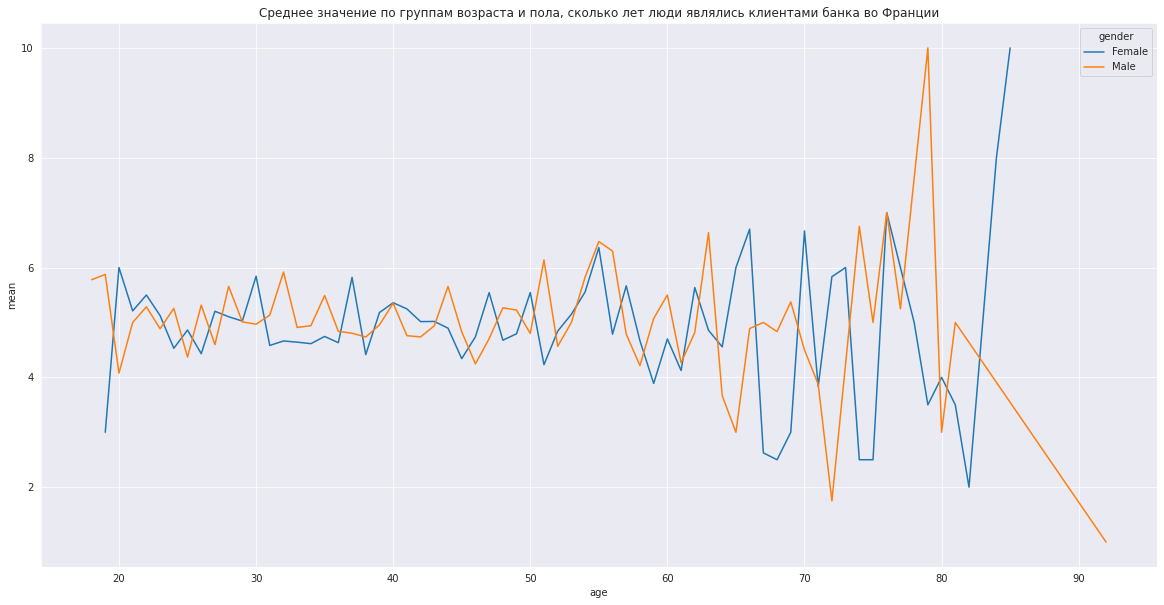

In [35]:
z[z['geography']=='France']
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.lineplot(data=z[z['geography']=='France'], x="age",y="mean",hue="gender",markers=True, dashes=False,ci=None)
plt.title('Среднее значение по группам возраста и пола, сколько лет люди являлись клиентами банка во Франции')
plt.show()

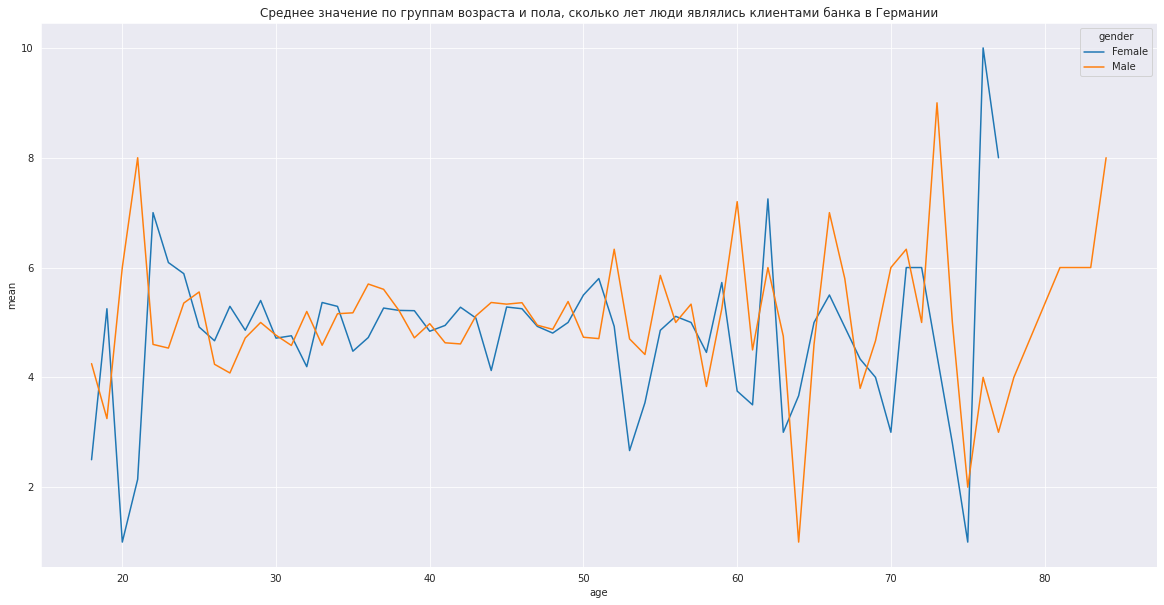

In [36]:

sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.lineplot(data=z[z['geography']=='Germany'], x="age",y="mean",hue="gender",markers=True, dashes=False,ci=None)
plt.title('Среднее значение по группам возраста и пола, сколько лет люди являлись клиентами банка в Германии')
plt.show()

In [37]:
df[(df['geography']=='Germany')&(df['age']==40)]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15745844,642,Germany,Female,40,6.0,129502.49,2,0,1,86099.23,1
15674551,535,Germany,Male,40,7.0,111756.50,1,1,0,8128.32,1
15576313,486,Germany,Female,40,9.0,71340.09,1,1,0,76192.21,0
15806467,568,Germany,Male,40,1.0,99282.63,1,0,0,134600.94,1
15677307,684,Germany,Female,40,NaN,137326.65,1,1,0,186976.60,0
...,...,...,...,...,...,...,...,...,...,...,...
15607634,606,Germany,Male,40,9.0,95293.86,2,0,1,96985.58,0
15617432,816,Germany,Female,40,9.0,109003.26,1,1,1,79580.56,0
15619514,507,Germany,Male,40,NaN,120105.43,1,1,0,92075.01,1


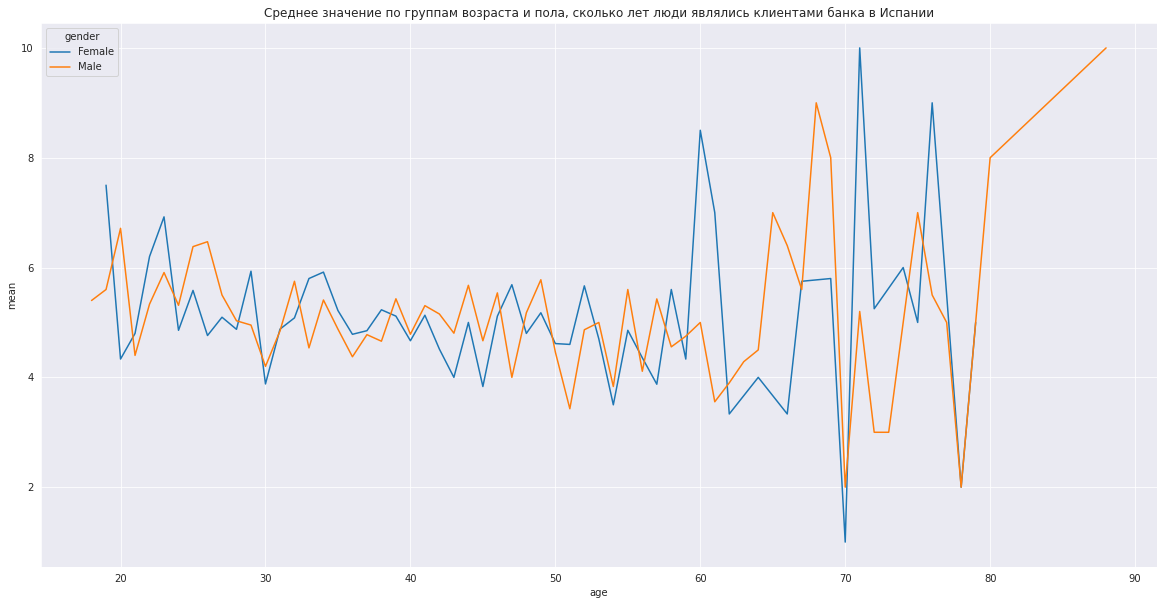

In [38]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.lineplot(data=z[z['geography']=='Spain'], x="age",y="mean",hue="gender",markers=True, dashes=False,ci=None)
plt.title('Среднее значение по группам возраста и пола, сколько лет люди являлись клиентами банка в Испании')
plt.show()

**Заметка**   
Видно что по годам есть изменения и если учесть еще и пол и страну то можно получить более точную картину, для заполнения пропусков

In [39]:
age_last = [i for i in range(18,25)]
for geography in df['geography'].unique():
    for gender in ['Female','Male']:
        res = df[(df['geography']==geography)&(df['gender']==gender)&(df['age'].isin(age_last))]['age'].value_counts()
        print(f'{geography}  {gender} \n{res} ')  
        

France  Female 
24    36
22    22
21    20
23    16
20     8
19     3
18     2
Name: age, dtype: int64 
France  Male 
24    37
23    29
22    23
20    13
21    11
18     9
19     8
Name: age, dtype: int64 
Spain  Female 
22    15
24    15
23    14
21     5
20     3
19     2
Name: age, dtype: int64 
Spain  Male 
24    17
22    13
23    13
20    10
19     6
21     6
18     5
Name: age, dtype: int64 
Germany  Female 
23    12
24     9
21     8
22     5
19     4
18     2
20     2
Name: age, dtype: int64 
Germany  Male 
24    18
23    15
22     6
18     4
19     4
20     4
21     3
Name: age, dtype: int64 


Можно наблюдать что кол-во людей мало, что является причиной почему так сильно графики начинают шуметь к повышению / понижению возраста, но говорить что это только из-за кол-ва тоже нельзя

### Смотрю возраст с малым числом людей

In [40]:
df[(df['age'] >= 18) & (df['age'] <= 23) & (df['tenure'].isna())].count()
# 7 % 

credit_score        22
geography           22
gender              22
age                 22
tenure               0
balance             22
num_of_products     22
has_credit_card     22
is_active_member    22
estimated_salary    22
exited              22
dtype: int64

В этой группе наны составляют 7 % от общего числа по каждому полу

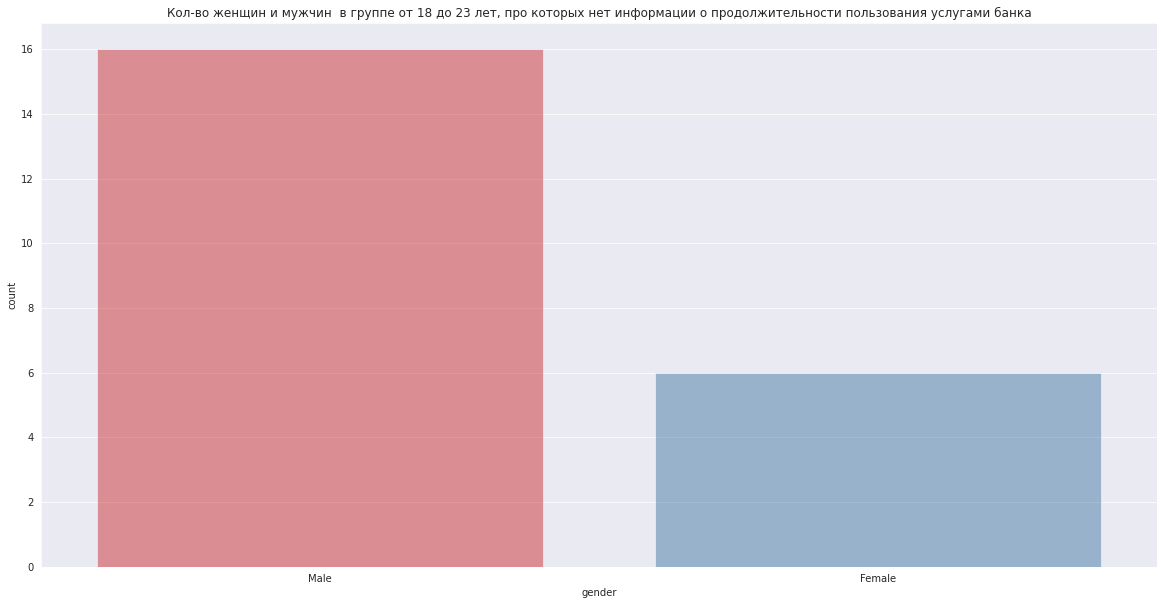

In [41]:
plt.figure(figsize=(20,10))
sns.countplot(data=df[(df['age'] >= 18) & (df['age'] <= 23) & (df['tenure'].isna())], x="gender", alpha=.5, palette="Set1")
plt.title('Кол-во женщин и мужчин  в группе от 18 до 23 лет, про которых нет информации о продолжительности пользования услугами банка')
plt.show()

In [42]:
df[(df['age'] >= 18) & (df['age'] <= 23) & (df['tenure'].isna())].count()

credit_score        22
geography           22
gender              22
age                 22
tenure               0
balance             22
num_of_products     22
has_credit_card     22
is_active_member    22
estimated_salary    22
exited              22
dtype: int64

In [43]:
df[(df['age'] >= 18) & (df['age'] <= 23)].count() 

credit_score        325
geography           325
gender              325
age                 325
tenure              303
balance             325
num_of_products     325
has_credit_card     325
is_active_member    325
estimated_salary    325
exited              325
dtype: int64

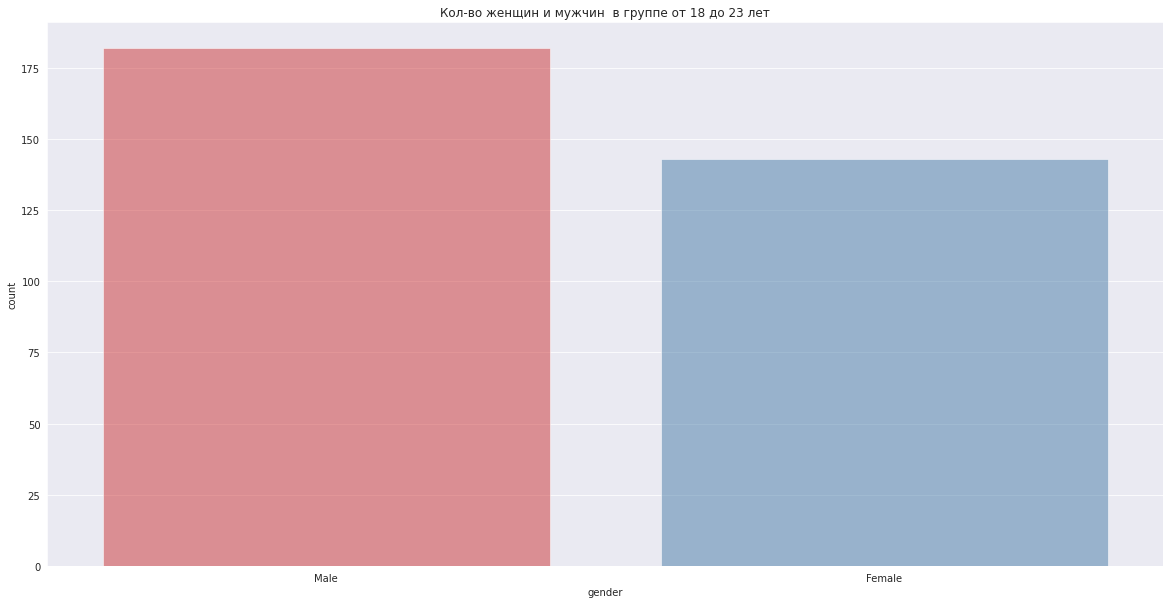

In [44]:
plt.figure(figsize=(20,10))
sns.countplot(data=df[(df['age'] >= 18) & (df['age'] <= 23)], x="gender", alpha=.5, palette="Set1")
plt.title('Кол-во женщин и мужчин  в группе от 18 до 23 лет')
plt.show()

In [45]:
df[(df['age'] >= 52) & (df['age'] <= 92) & (df['tenure'].isna())].count()

credit_score        97
geography           97
gender              97
age                 97
tenure               0
balance             97
num_of_products     97
has_credit_card     97
is_active_member    97
estimated_salary    97
exited              97
dtype: int64

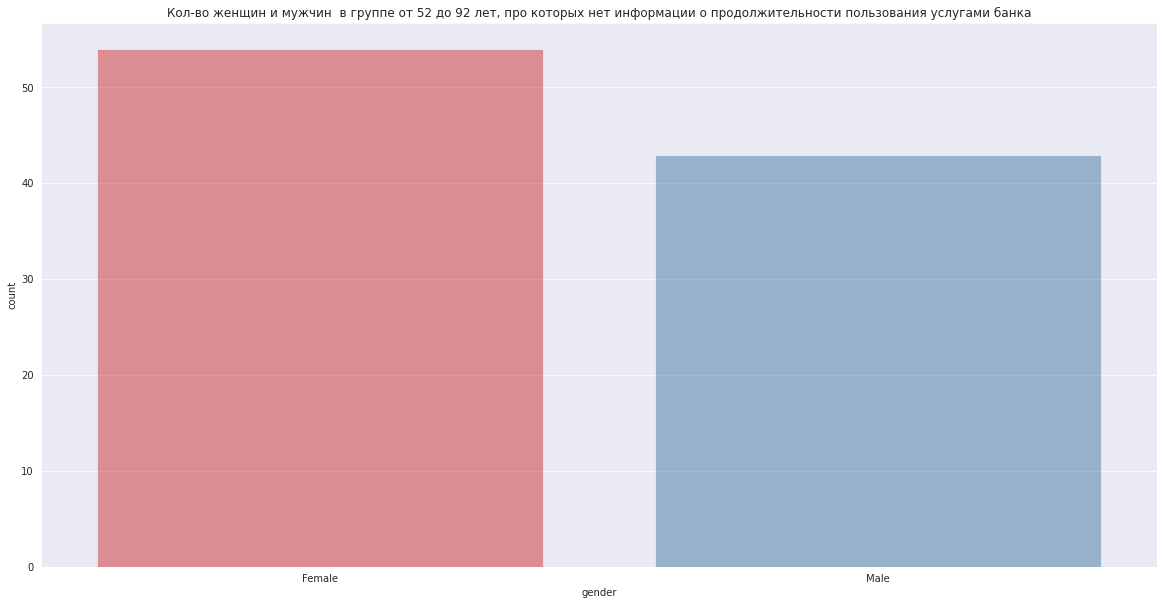

In [46]:
plt.figure(figsize=(20,10))
sns.countplot(data=df[(df['age'] >= 52) & (df['age'] <= 92) & (df['tenure'].isna())], x="gender", alpha=.5, palette="Set1")
plt.title('Кол-во женщин и мужчин  в группе от 52 до 92 лет, про которых нет информации о продолжительности пользования услугами банка')
plt.show()

In [47]:
df[(df['age'] >= 52) & (df['age'] <= 92)].count()

credit_score        1142
geography           1142
gender              1142
age                 1142
tenure              1045
balance             1142
num_of_products     1142
has_credit_card     1142
is_active_member    1142
estimated_salary    1142
exited              1142
dtype: int64

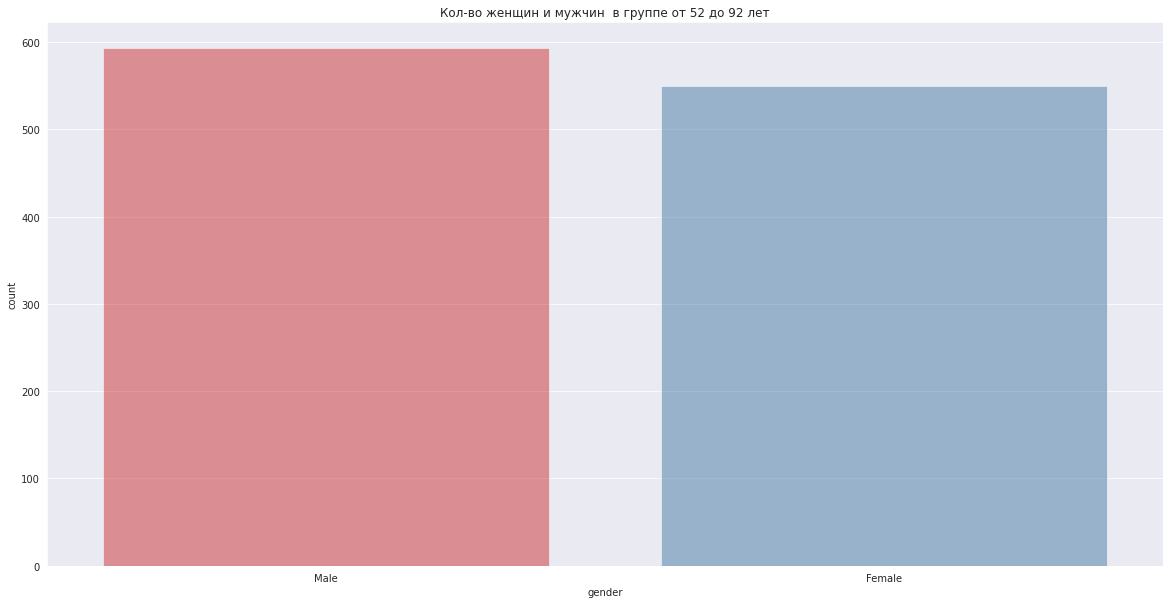

In [48]:
plt.figure(figsize=(20,10))
sns.countplot(data=df[(df['age'] >= 52) & (df['age'] <= 92)], x="gender", alpha=.5, palette="Set1")
plt.title('Кол-во женщин и мужчин  в группе от 52 до 92 лет')
plt.show()

В этой группе наны составляют 8 % от общего числа

In [49]:
df[(df['age'] < 52) & (df['age'] > 23) & (df['tenure'].isna())].count()

credit_score        790
geography           790
gender              790
age                 790
tenure                0
balance             790
num_of_products     790
has_credit_card     790
is_active_member    790
estimated_salary    790
exited              790
dtype: int64

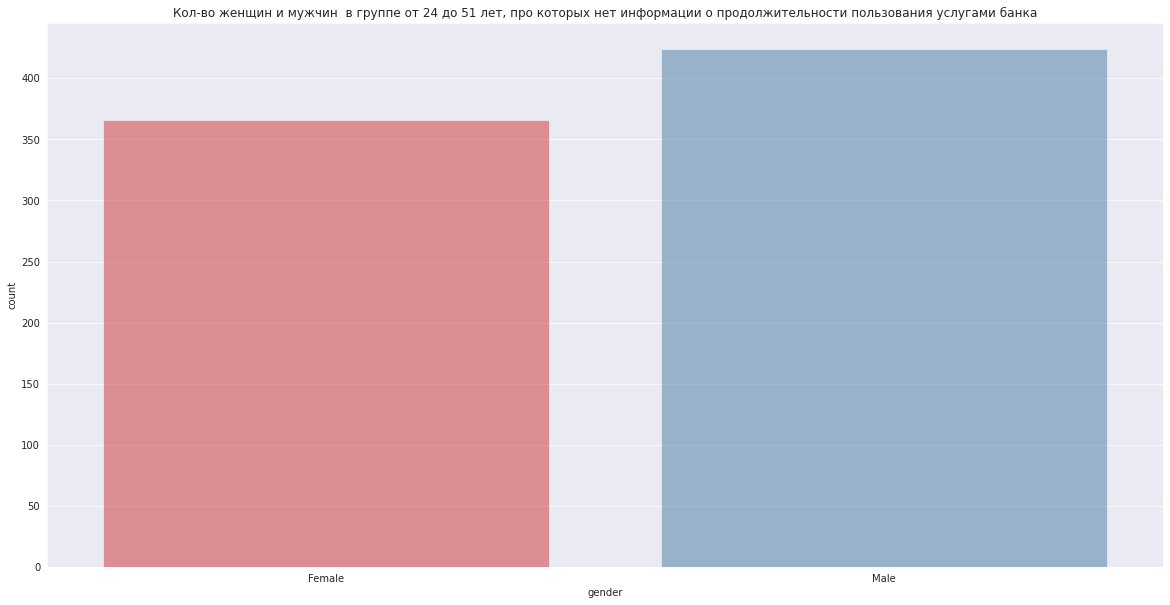

In [50]:
plt.figure(figsize=(20,10))
sns.countplot(data=df[(df['age'] < 52) & (df['age'] > 23) & (df['tenure'].isna())], x="gender", alpha=.5, palette="Set1")
plt.title('Кол-во женщин и мужчин  в группе от 24 до 51 лет, про которых нет информации о продолжительности пользования услугами банка')
plt.show()

In [51]:
df[(df['age'] < 52) & (df['age'] > 23)].count()

credit_score        8533
geography           8533
gender              8533
age                 8533
tenure              7743
balance             8533
num_of_products     8533
has_credit_card     8533
is_active_member    8533
estimated_salary    8533
exited              8533
dtype: int64

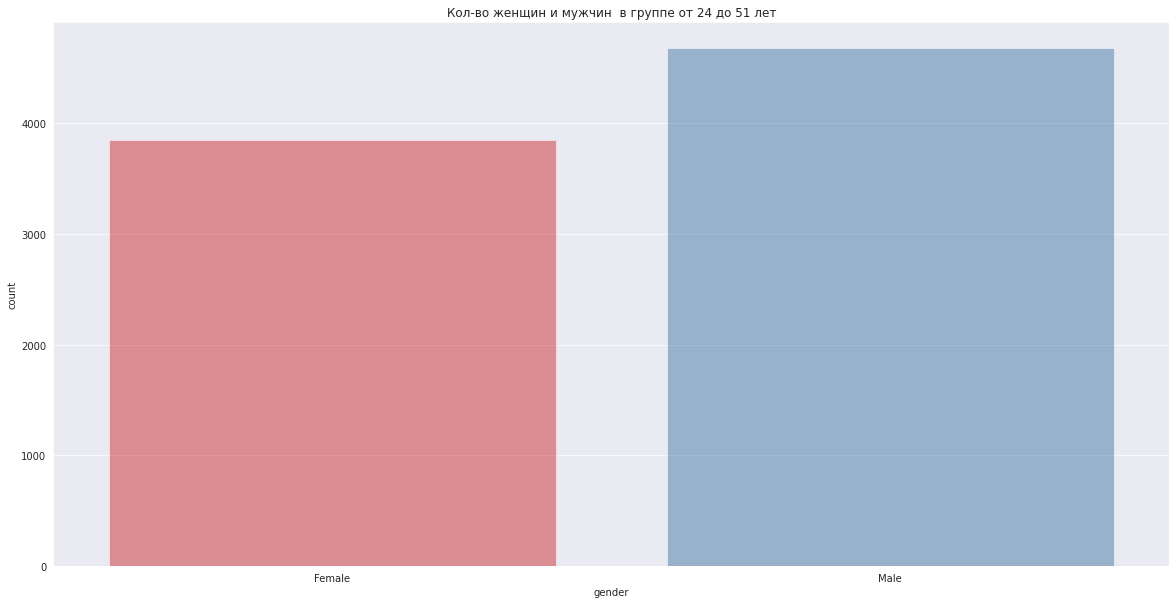

In [52]:
plt.figure(figsize=(20,10))
sns.countplot(data=df[(df['age'] < 52) & (df['age'] > 23)], x="gender", alpha=.5, palette="Set1")
plt.title('Кол-во женщин и мужчин  в группе от 24 до 51 лет')
plt.show()

В этой группе наны составляют 9 % от общего числа

На основе гарфиков можно сделать вывод, что  наны заменять лучше на среднее значение возраста по стране и полу  
Если говорить в общем то группа от 52 лет покрывает "шумящие" графики, но при более детальном рассмотрении видно что шум от 52 начинается в Германии, в то время как в Испании и Франции это начинает происходить от 60 (эта цифра была рассмотренна на достаточность кол-ва людей)


Разобью учитывая пол :  
18 - 23  
24 - 30  
31 - 35    
36 - 40    
41 - 45  
46 - 51  
  
далее 
  
испания, франция   
52 - 60   
60 - 93  
германия   
51 - 93   


На основе полученных данных такое разбитие поможет избавить от резких перепапдов по возрастам и дать более реальную картину того что должно в пропусках


In [53]:
intervals_sp_fr = [17,23,30,35,40,45,51,60,93]
intervals_ger = [17,23,30,35,40,45,51,93]

In [54]:
df['age_bins'] = pd.cut(df['age'], bins=intervals_sp_fr)


In [55]:
medians_fr_sp = df[df['geography'].isin(['France',
                                         'Spain'])].groupby(['geography',
                                                             'gender',
                                                             'age_bins'])['tenure'].median().transform(lambda x : round(x))

In [56]:
medians_fr_sp = medians_fr_sp.reset_index()
medians_fr_sp

,geography,gender,age_bins,tenure
0,France,Female,"(17, 23]",5
1,France,Female,"(23, 30]",5
2,France,Female,"(30, 35]",4
3,France,Female,"(35, 40]",5
4,France,Female,"(40, 45]",5
5,France,Female,"(45, 51]",5
6,France,Female,"(51, 60]",5
7,France,Female,"(60, 93]",5
8,France,Male,"(17, 23]",5
9,France,Male,"(23, 30]",5


In [57]:
df_merged = df.merge(medians_fr_sp,on=['geography','gender','age_bins'], how='left')
df_merged['tenure'] = df_merged['tenure_x'].fillna(df_merged['tenure_y'])
df = df_merged.drop(columns=['tenure_x','tenure_y'])


In [58]:
df['age_bins'] = pd.cut(df['age'], bins=intervals_ger)

In [59]:
median_ger = df[df['geography'] == 'Germany'].groupby(['geography','gender','age_bins'])['tenure'].median().transform(lambda x : round(x))

In [60]:
median_ger = median_ger.reset_index()
median_ger

,geography,gender,age_bins,tenure
0,Germany,Female,"(17, 23]",4
1,Germany,Female,"(23, 30]",5
2,Germany,Female,"(30, 35]",5
3,Germany,Female,"(35, 40]",5
4,Germany,Female,"(40, 45]",5
5,Germany,Female,"(45, 51]",5
6,Germany,Female,"(51, 93]",5
7,Germany,Male,"(17, 23]",5
8,Germany,Male,"(23, 30]",5
9,Germany,Male,"(30, 35]",5


In [61]:
df_merged = df.merge(median_ger, on=['geography','gender','age_bins'], how='left')
df_merged['tenure'] = df_merged['tenure_x'].fillna(df_merged['tenure_y'])
df = df_merged.drop(columns=['tenure_x','tenure_y'])


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      10000 non-null  int64   
 1   geography         10000 non-null  object  
 2   gender            10000 non-null  object  
 3   age               10000 non-null  int64   
 4   balance           10000 non-null  float64 
 5   num_of_products   10000 non-null  int64   
 6   has_credit_card   10000 non-null  int64   
 7   is_active_member  10000 non-null  int64   
 8   estimated_salary  10000 non-null  float64 
 9   exited            10000 non-null  int64   
 10  age_bins          10000 non-null  category
 11  tenure            10000 non-null  float64 
dtypes: category(1), float64(3), int64(6), object(2)
memory usage: 947.7+ KB


In [63]:
df['tenure'] = df['tenure'].astype(int)
df.drop('age_bins', inplace=True, axis=1)
df.insert(7, 'tenure', df.pop('tenure'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   balance           10000 non-null  float64
 5   num_of_products   10000 non-null  int64  
 6   has_credit_card   10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


### смотрю на корреляцию 

In [64]:
df.describe()

,credit_score,age,balance,num_of_products,has_credit_card,tenure,is_active_member,estimated_salary,exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,650.53,38.92,76485.89,1.53,0.71,4.99,0.52,100090.24,0.2
std,96.65,10.49,62397.41,0.58,0.46,2.76,0.50,57510.49,0.4
min,350.00,18.00,0.00,1.00,0.00,0.00,0.00,11.58,0.0
25%,584.00,32.00,0.00,1.00,0.00,3.00,0.00,51002.11,0.0
50%,652.00,37.00,97198.54,1.00,1.00,5.00,1.00,100193.91,0.0
75%,718.00,44.00,127644.24,2.00,1.00,7.00,1.00,149388.25,0.0
max,850.00,92.00,250898.09,4.00,1.00,10.00,1.00,199992.48,1.0


<AxesSubplot:title={'center':'Корреляция признаков'}>

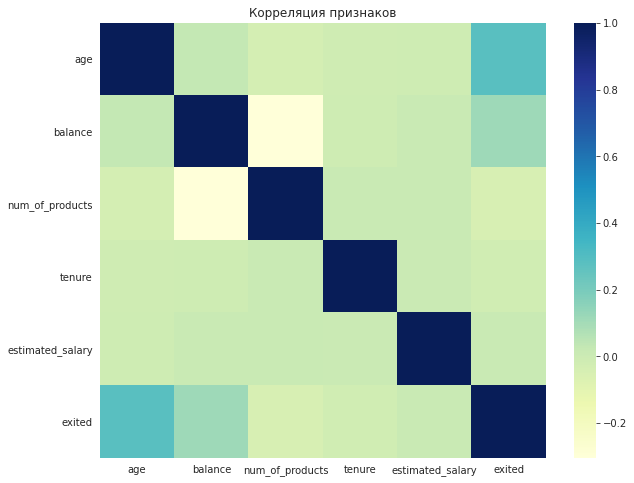

In [65]:
plt.figure(figsize=(10, 8))
corr_matrix = df[['age','balance','num_of_products','tenure','estimated_salary','exited']].corr()
plt.title('Корреляция признаков')
sns.heatmap(corr_matrix, cmap="YlGnBu")

Видно, что таргет имеет слаюбую связь с возрастом  

### Обработка категориальных признаков,

In [66]:
def ohe_encode(df, cat_name):
    cat = df[cat_name]
    cat_encoded = pd.get_dummies(cat, prefix=cat_name,drop_first=True)
    df_encoded = pd.concat([df,cat_encoded], axis=1)
    df_encoded = df_encoded.drop(columns=[cat_name])
    
    return df_encoded


In [67]:
names_toencode = df.select_dtypes(exclude=['number']).columns
for name in names_toencode:
    df = ohe_encode(df, name)


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   balance            10000 non-null  float64
 3   num_of_products    10000 non-null  int64  
 4   has_credit_card    10000 non-null  int64  
 5   tenure             10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 810.5 KB


<AxesSubplot:title={'center':'Корреляция признаков с OHE'}>

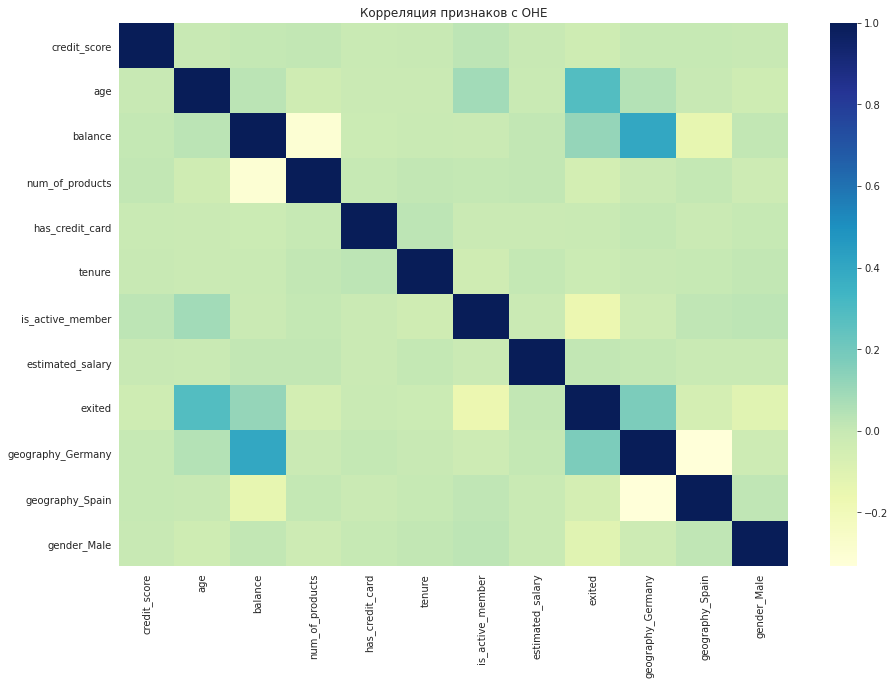

In [69]:
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
plt.title('Корреляция признаков с OHE')
sns.heatmap(corr_matrix, cmap="YlGnBu")

После применения OHE в  дамми-ловушку не попали

### Добавление фич 

In [70]:
df['balance_es'] = df['balance']/df['estimated_salary'] 
df.loc[df['balance_es']== np.inf,'balance_es'] = -1

In [71]:
numerical_names.append('balance_es')

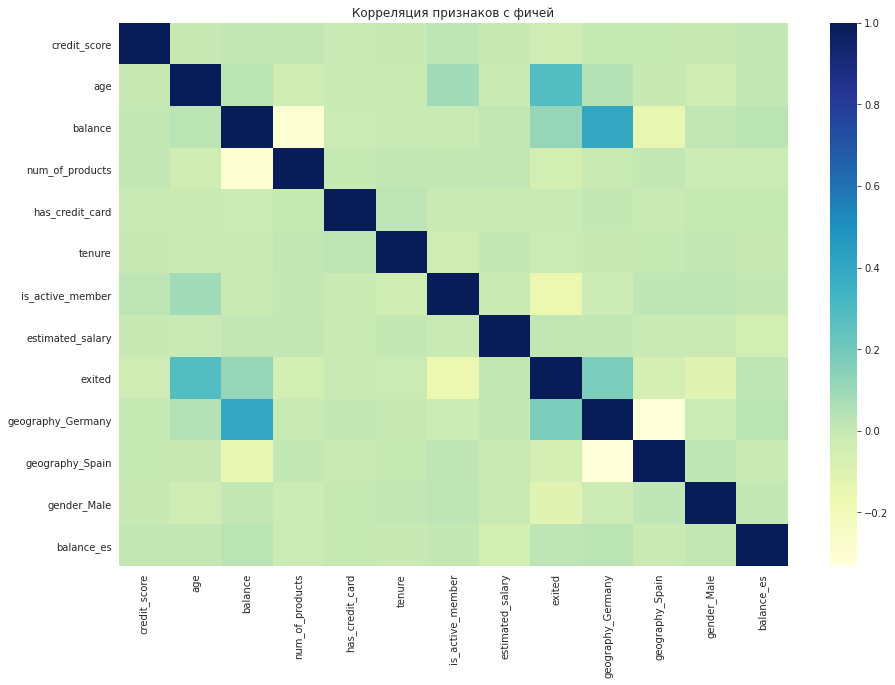

In [72]:
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.title('Корреляция признаков с фичей')
plt.show()

После добавления фичи избежали появления линейной связи с другими признаками

### Вывод

Заемщики по странам распределены следующим образом :  

- France 5014  
- Germany 2509  
- Spain 2477  
Франция имеет клиентов почти столько же сколько и Германия с Испанией вместе.  
  


Удалены столбцы : row_number,surname , так как они бесполезны для обучении модели  
Столбец customer_id был выставлен вместо индексов  
  
  
Есть много клиентов с нулевым - около нулевым балансом  
Остальные данные по взгляду на данные графики хоть и имеют некоторые 'выбросы', но все эти выбросы похожи на реальность.  
   
Названия колонок были приведены к snake_case и были выделены следующие категории :  
  
**категориальные бинарные признаки**

gender
has_credit_card
is_active_member   

-----

**количественные непрерывные**  

balance
estimated_salary  

-----
  
**количественные дискретные**  

credit_score
age
tenure
num_of_products

-----


Явных дубликатов - нет   

После применения OHE в  дамми-ловушку не попали   


 

На основе гарфиков был сделан вывод, что наны заменять лучше на среднее значение возраста по стране и полу
Если говорить в общем то группа от 52 лет покрывает "шумящие" графики, но при более детальном рассмотрении видно что шум от 52 начинается в Германии, в то время как в Испании и Франции это начинает происходить от 60 (эта цифра была рассмотренна на достаточность кол-ва людей)

Интервалы разбивки учитывая пол :  
18 - 23  
24 - 30  
31 - 35  
36 - 40  
41 - 45  
46 - 51  

далее  

испания, франция  
52 - 60  
60 - 93  
германия  
51 - 93  

Такое разбитие поможет избавить от резких перепапдов по возрастам и дать более реальную картину того что должно в пропусках  


Была добавлена фича - отношение баланса к остатку (в случае бесконечности стоит -1)

## Исследование задачи

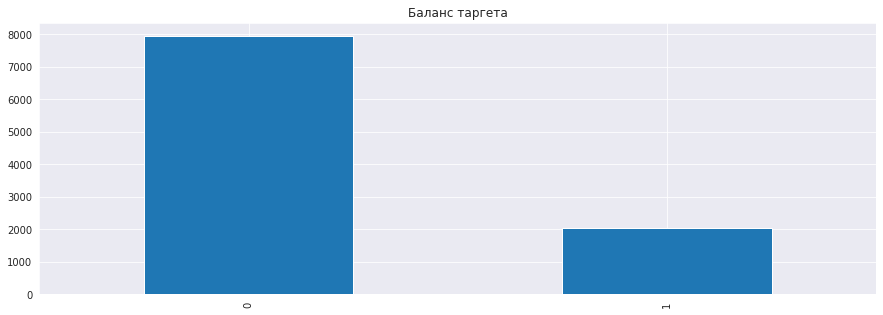

In [73]:
df['exited'].value_counts().plot(kind='bar',figsize=(15,5))
plt.title('Баланс таргета')
plt.show()

Дисбаланс примерно 1 к 4

In [74]:
scaler = StandardScaler()  #  RobustScaler()

model = RandomForestClassifier(random_state=42)

column_transformer = make_column_transformer((make_imblearn_pipeline(scaler), numerical_names),
                                             remainder='passthrough')


Использовал стандартизацию для решения задачи масштабирования

In [75]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['credit_score', 'age', 'tenure',
                                  'num_of_products', 'estimated_salary',
                                  'balance', 'balance_es'])])

In [76]:
pipeline = make_imblearn_pipeline(column_transformer, model) 

Применил стандартизацию к числовым столбцам

In [77]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['credit_score', 'age',
                                                   'tenure', 'num_of_products',
                                                   'estimated_salary',
                                                   'balance',
                                                   'balance_es'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [78]:
X = df.drop('exited',axis=1)
y=df['exited']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [79]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['credit_score', 'age',
                                                   'tenure', 'num_of_products',
                                                   'estimated_salary',
                                                   'balance',
                                                   'balance_es'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [80]:
scoring = {'roc_auc': 'roc_auc', 'f1': make_scorer(f1_score)}

In [81]:
pipeline.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('pipeline',
                                   Pipeline(steps=[('standardscaler',
                                                    StandardScaler())]),
                                   ['credit_score', 'age', 'tenure',
                                    'num_of_products', 'estimated_salary',
                                    'balance', 'balance_es'])])),
 ('randomforestclassifier', RandomForestClassifier(random_state=42))]

In [82]:

param_grid = [
    {'randomforestclassifier': [LogisticRegression(random_state=42)], 
                 'randomforestclassifier__penalty': ['l1', 'l2'], 
                 'randomforestclassifier__C': [10**i for i in range(-3,4)]},
    
    {'randomforestclassifier': [RandomForestClassifier(random_state=42)], 
                 'randomforestclassifier__n_estimators': list(range(10,131,10)), 
                 'randomforestclassifier__max_depth': list(range(5,16,1)), 
                 'randomforestclassifier__min_samples_split' : [i for i in range(2,11)]}, 
    
    {'randomforestclassifier': [KNeighborsClassifier()], 
             'randomforestclassifier__n_neighbors' : list(range(10,131,10)), 
             'randomforestclassifier__weights' : ['distance','uniform'], 
             'randomforestclassifier__algorithm': ['ball_tree','kd_tree','brute']}
    
]

grid = RandomizedSearchCV(pipeline,
                    param_grid,
                    n_iter=30,
                    cv=3,
                    verbose=1,
                    random_state=42,
                    scoring=['f1', 'roc_auc'],
                    n_jobs=-1, refit='f1')

grid.fit(X_train, y_train)    

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'tenure',
                                                                                'num_of_products',
                                                                                'estimated_salary',
                                                                                'balance',
                                                                                'balance_es'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state...
                                                                                  70,
                                                                                  80,
                                                                                  90,
                                                                                  100,
                                                                                  110,
                                                                                  120,
                                                                                  130]},
                                        {'randomforestclassifier': [KNeighborsClassifier()],
                                         'randomforestclassifier__algorithm': ['ball_tree',
                                                                               'kd_tree',
                                                                               'brute'],
                                         'randomforestclassifier__n_neighbors': [10,
                                                                                 20,
                                                                                 30,
                                                                                 40,
                                                                                 50,
                                                                                 60,
                                                                                 70,
                                                                                 80,
                                                                                 90,
                                                                                 100,
                                                                                 110,
                                                                                 120,
                                                                                 130],
                                         'randomforestclassifier__weights': ['distance',
                                                                             'uniform']}],
                   random_state=42, refit='f1', scoring=['f1', 'roc_auc'],
                   verbose=1)

In [83]:
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['credit_score', 'age',
                                                   'tenure', 'num_of_products',
                                                   'estimated_salary',
                                                   'balance',
                                                   'balance_es'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=14, min_samples_split=5,
                                        n_estimators=110, random_state=42))])

In [84]:
grid.best_params_

{'randomforestclassifier__n_estimators': 110,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__max_depth': 14,
 'randomforestclassifier': RandomForestClassifier(max_depth=14, min_samples_split=5, n_estimators=110,
                        random_state=42)}

In [85]:
grid.best_score_

0.5823559376681781

In [86]:
grid.cv_results_

{'mean_fit_time': array([0.067324  , 0.64637725, 0.59663256, 0.46827881, 0.55604935,
        0.85796603, 0.56623642, 0.01659815, 0.57545455, 0.09035206,
        0.19087338, 0.0648214 , 0.4435931 , 0.07363176, 0.30548914,
        0.73701859, 0.13636049, 0.32031584, 0.30977694, 0.19434102,
        0.26347009, 0.19005354, 0.05487831, 0.19232051, 0.55695176,
        0.77002645, 0.60494955, 0.89216693, 0.17779199, 0.56289474]),
 'std_fit_time': array([0.00199582, 0.0127216 , 0.01967074, 0.02520841, 0.00566331,
        0.01238418, 0.00676667, 0.00111796, 0.00938225, 0.0029457 ,
        0.00341223, 0.0025323 , 0.01107993, 0.0012181 , 0.00297096,
        0.01027306, 0.00802484, 0.00562061, 0.00385673, 0.00237099,
        0.00669736, 0.00390566, 0.00059777, 0.0082442 , 0.00800853,
        0.03987887, 0.00531149, 0.02533472, 0.00393604, 0.05338676]),
 'mean_score_time': array([0.02159389, 0.11398355, 0.10427618, 0.08612092, 0.09949692,
        0.15417544, 0.10539627, 0.82867328, 0.10037915, 0.02

In [87]:
index_best_score_f1 = np.argmax(grid.cv_results_['mean_test_f1'])

In [88]:
roc_auc_for_f1 = grid.cv_results_['mean_test_roc_auc'][index_best_score_f1]

In [89]:
roc_auc_for_f1

0.852810842979053

**Вывод :**   

- В результате применения трех моделей с использованием рандомного поиска по сетке была найдена наилучшая модель RandomForestClassifier с гиперпараметрами max_depth=14, min_samples_split=5, n_estimators=110 и random_state=42.  
- Лучшее значение метрики f1 - 0.58235 roc_auc на том же этапе кросс-валидации -  0.85281  
- Значение метрики roc_auc выше чем значение f1, что указывает на то, что модель лучше разделяет, чем выделяет положительные объекты. (дисбаланс) 

## Борьба с дисбалансом

In [90]:
new_pipeline = make_imblearn_pipeline(column_transformer,SMOTE(random_state=42) , model) 
new_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['credit_score', 'age',
                                                   'tenure', 'num_of_products',
                                                   'estimated_salary',
                                                   'balance',
                                                   'balance_es'])])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

На основании анализа данных в первом пункте было принято решение использовать алгоритм SMOTE для балансировки классов, вместо ADASYN. Это связано с тем, что данные не имеют характерных разделений или "колец", и разбиение по границе может привести к ухудшению качества модели.

Таким образом, выбор алгоритма SMOTE был обоснован на основании характеристик данных и потенциального влияния на качество модели.

In [91]:
param_grid = [
    {'randomforestclassifier': [LogisticRegression(random_state=42)], 
                 'randomforestclassifier__penalty': ['l1', 'l2'], 
                 'randomforestclassifier__C': [10**i for i in range(-3,4)]},
    
    {'randomforestclassifier': [RandomForestClassifier(random_state=42)], 
                 'randomforestclassifier__n_estimators': [i for i in range(10,131,10)], 
                 'randomforestclassifier__max_depth': list(range(5,16,1)), 
                 'randomforestclassifier__min_samples_split' : [i for i in range(2,11)]}, 
    
    {'randomforestclassifier': [KNeighborsClassifier()], 
             'randomforestclassifier__n_neighbors' : [i for i in range(10,131,10)], 
             'randomforestclassifier__weights' : ['distance','uniform'], 
             'randomforestclassifier__algorithm': ['ball_tree','kd_tree','brute']}
    
]

grid = RandomizedSearchCV(new_pipeline,
                    param_grid,
                    n_iter=30,
                    cv=5,
                    verbose=1,
                    random_state=42,
                    scoring=['f1','roc_auc'],
                    n_jobs=-1, refit='f1')

grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['credit_score',
                                                                                'age',
                                                                                'tenure',
                                                                                'num_of_products',
                                                                                'estimated_salary',
                                                                                'balance',
                                                                                'balance_es'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('randomforestclassifier',
                                              Ra...
                                                                                  70,
                                                                                  80,
                                                                                  90,
                                                                                  100,
                                                                                  110,
                                                                                  120,
                                                                                  130]},
                                        {'randomforestclassifier': [KNeighborsClassifier()],
                                         'randomforestclassifier__algorithm': ['ball_tree',
                                                                               'kd_tree',
                                                                               'brute'],
                                         'randomforestclassifier__n_neighbors': [10,
                                                                                 20,
                                                                                 30,
                                                                                 40,
                                                                                 50,
                                                                                 60,
                                                                                 70,
                                                                                 80,
                                                                                 90,
                                                                                 100,
                                                                                 110,
                                                                                 120,
                                                                                 130],
                                         'randomforestclassifier__weights': ['distance',
                                                                             'uniform']}],
                   random_state=42, refit='f1', scoring=['f1', 'roc_auc'],
                   verbose=1)

In [92]:
grid.best_score_

0.6140508334977605

In [93]:
index_best_score_f1 = np.argmax(grid.cv_results_['mean_test_f1'])

In [94]:
roc_auc_for_f1 = grid.cv_results_['mean_test_roc_auc'][index_best_score_f1]

In [95]:
roc_auc_for_f1

0.8562456419419506

In [96]:
grid.best_params_

{'randomforestclassifier__n_estimators': 130,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier': RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=130,
                        random_state=42)}

**Вывод**  
Для борьбы с дисбалансом классов были использованы RandomizedSearchCV и SMOTE. Использование их вместе помогает улучшить качество модели.    
Здесь была выделен RandomForestClassifier() как лучшая модель со следующими гиперпараметрами : max_depth=10, min_samples_split=3, n_estimators=130,random_state=42 .      
f1 = 0.6140508334977605  
roc_auc = 0.8562456419419506 на том же этапе что и f1 


## Тестирование модели

In [97]:
predict = grid.predict(X_test) 
probs = grid.predict_proba(X_test)[:,1]
f1_test = f1_score(y_test, predict)

In [98]:
f1_test


0.6226053639846744

In [99]:
roc_auc_score(y_test, predict)

0.7715448959357744

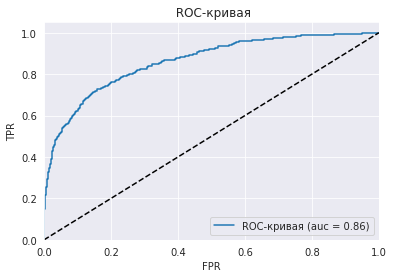

In [100]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# построение кривой ROC
plt.plot(fpr, tpr, label='ROC-кривая (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(' ROC-кривая')
plt.legend(loc="lower right")
plt.show()


**В результате проведенного исследования получено:**

1. Данные были подготовлены путем заполнения пропусков, добавления новой фичи и обработки категориальных признаков методом OHE.

2. Был обнаружен дисбаланс классов (1 к 4).

3. Были изучены модели без учета дисбаланса.

4. Для борьбы с дисбалансом классов были использованы RandomizedSearchCV и SMOTE. Применение этих методов вместе помогло улучшить качество модели.

5. В результате применения методов борьбы с дисбалансом классов удалось увеличить значения f1_score и roc_auc_score с 0.58235 и 0.85281 до 0.61405 и 0.856245 соответственно. 
6. Незначительное повышение метрики roc-auc может быть связано с тем что метрика roc-auc менее чувствительна к изменениям в классификационных порогах, чем f1. 
7. На тесте f1 выросла, что показывает что модель лучше классифицирует на тесте,  значение площади под рок-кривой 0,86, что показывает, что модель имеет хорошую способность разделять на классы.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*